In [28]:
import os
import pickle
import matplotlib
import numpy as np
import typing as t
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.ndimage import center_of_mass

from v1t.utils import utils, tensorboard

utils.set_random_seed(1234)

tensorboard.set_font()

In [29]:
OUTPUT_DIR = "../runs/best_v1t_sensorium"
PLOT_DIR = os.path.join(OUTPUT_DIR, "plots")

with open(os.path.join(OUTPUT_DIR, "attention_rollout_maps.pkl"), "rb") as file:
    results = pickle.load(file)

### Computer correlation between attention maps and behavior variables

In [30]:
def computer_centers(heatmaps: np.ndarray):
    centers = np.zeros((len(heatmaps), 2), dtype=np.float32)
    for i, heatmap in enumerate(heatmaps):
        y, x = center_of_mass(heatmap)
        centers[i, 0], centers[i, 1] = x, y
    mid_point = np.array([64 / 2, 36 / 2])
    centers = centers - mid_point
    return centers


def abs_correlation(x: np.ndarray, y: np.ndarray) -> t.Tuple[float, str]:
    """Return the absolute Pearson correlation and its p-value in asterisk"""
    corr, p_value = pearsonr(x, y)
    asterisks = "n.s."
    if p_value <= 0.0001:
        asterisks = "****"
    elif p_value <= 0.001:
        asterisks = "***"
    elif p_value <= 0.01:
        asterisks = "**"
    elif p_value <= 0.05:
        asterisks = "*"
    return np.abs(corr), asterisks

In [31]:
center_corrs, dilation_corrs = {"x": [], "y": []}, {"x": [], "y": []}
for mouse_id, mouse_dict in results["test"].items():
    print(f"Mouse {mouse_id}")
    # compute correlation center of mass and pupil center
    mass_centers = computer_centers(mouse_dict["heatmaps"])
    pupil_centers = mouse_dict["pupil_centers"]
    corr_x, p_x = abs_correlation(mass_centers[:, 0], pupil_centers[:, 0])
    corr_y, p_y = abs_correlation(mass_centers[:, 1], pupil_centers[:, 1])
    center_corrs["x"].append(corr_x)
    center_corrs["y"].append(corr_y)
    print(
        f"\tAbs. Corr(center of mass, pupil center)\n"
        f"\tx-axis: {corr_x:.03f} ({p_x})\n\ty-axis: {corr_y:.03f} ({p_y})"
    )

    # standard deviation in x and y axes
    spread_x = np.std(np.sum(mouse_dict["heatmaps"], axis=1), axis=1)
    spread_y = np.std(np.sum(mouse_dict["heatmaps"], axis=2), axis=1)
    dilation = mouse_dict["behaviors"][:, 0]
    # absolute correlation between pupil dilation and attention map
    # standard deviation
    corr_x, p_x = abs_correlation(spread_x, dilation)
    corr_y, p_y = abs_correlation(spread_y, dilation)
    dilation_corrs["x"].append(corr_x)
    dilation_corrs["y"].append(corr_y)
    print(
        f"\tAbs. Corr(attention map std, pupil dilation)\n"
        f"\tx-axis: {corr_x:.03f} ({p_x})\n\ty-axis: {corr_y:.03f} ({p_y})"
    )

print(
    f"\nAvg. Corr(center of mass, pupil center)\n"
    f'\tx-axis: {np.mean(center_corrs["x"]):.03f} \pm {np.std(center_corrs["x"]):.03f}\n'
    f'\ty-axis: {np.mean(center_corrs["y"]):.03f} \pm {np.std(center_corrs["y"]):.03f}\n'
)

Mouse A
	Abs. Corr(center of mass, pupil center)
	x-axis: 0.682 (****)
	y-axis: 0.568 (****)
	Abs. Corr(attention map std, pupil dilation)
	x-axis: 0.302 (****)
	y-axis: 0.323 (****)
Mouse B
	Abs. Corr(center of mass, pupil center)
	x-axis: 0.489 (****)
	y-axis: 0.493 (****)
	Abs. Corr(attention map std, pupil dilation)
	x-axis: 0.245 (****)
	y-axis: 0.177 (****)
Mouse C
	Abs. Corr(center of mass, pupil center)
	x-axis: 0.505 (****)
	y-axis: 0.370 (****)
	Abs. Corr(attention map std, pupil dilation)
	x-axis: 0.184 (****)
	y-axis: 0.121 (***)
Mouse D
	Abs. Corr(center of mass, pupil center)
	x-axis: 0.484 (****)
	y-axis: 0.310 (****)
	Abs. Corr(attention map std, pupil dilation)
	x-axis: 0.023 (n.s.)
	y-axis: 0.202 (****)
Mouse E
	Abs. Corr(center of mass, pupil center)
	x-axis: 0.464 (****)
	y-axis: 0.302 (****)
	Abs. Corr(attention map std, pupil dilation)
	x-axis: 0.262 (****)
	y-axis: 0.220 (****)

Avg. Corr(center of mass, pupil center)
	x-axis: 0.525 \pm 0.080
	y-axis: 0.409 \pm 0

### Overlay attention rollout map on visual stimulus

In [53]:
def to_rgb(image: np.ndarray):
    assert image.shape[0] == 2
    blue, green = image[0][..., None], image[1][..., None]
    red = np.zeros_like(blue)
    return np.concatenate((red, blue, green), axis=-1)


def plot_attention_maps(
    val_results: t.Dict[str, np.ndarray],
    test_results: t.Dict[str, np.ndarray],
    filename: str = None,
    colormap: str = "turbo",
    alpha: float = 0.5,
    num_images: int = 3,
):
    cmap = matplotlib.colormaps.get_cmap(colormap)
    colors = cmap(np.arange(256))[:, :3]
    label_fontsize, tick_fontsize = 10, 8
    x_labelpad, y_labelpad = 2, 1
    figure, axes = plt.subplots(
        nrows=2,
        ncols=num_images,
        figsize=(8, 4),
        gridspec_kw={"wspace": 0.05, "hspace": -0.25},
        dpi=240,
    )
    for i in range(num_images):
        image = val_results["images"][i]
        heatmap = val_results["heatmaps"][i]
        behavior = val_results["behaviors"][i]
        pupil_center = val_results["pupil_centers"][i]
        gray_image = image.shape[0] == 1
        image = image[0] if gray_image else to_rgb(image)
        heatmap = colors[np.uint8(255.0 * heatmap)] * 255.0
        image = image[..., None] if gray_image else image
        heatmap = alpha * heatmap + (1 - alpha) * image
        # heatmap = heatmap * image
        axes[0, i].imshow(heatmap.astype(np.uint8), cmap=colormap)
        axes[0, i].set_xticks([])
        axes[0, i].set_yticks([])
        tensorboard.remove_spines(axis=axes[0, i])
        description = (
            f"[{behavior[0]:.01f}, "  # pupil dilation
            f"{behavior[1]:.01f}, "  # dilation derivative
            f"({pupil_center[0]:.01f}, {pupil_center[1]:.01f}), "  # pupil center
            f"{behavior[2]:.01f}]"  # speed
        )
        axes[0, i].set_xlabel(description, labelpad=x_labelpad, fontsize=tick_fontsize)
    axes[0, 0].set_ylabel(
        "Validation samples", labelpad=y_labelpad, fontsize=tick_fontsize
    )
    for i in range(num_images):
        image = test_results["images"][i]
        heatmap = test_results["heatmaps"][i]
        behavior = test_results["behaviors"][i]
        pupil_center = test_results["pupil_centers"][i]
        gray_image = image.shape[0] == 1
        image = image[0] if gray_image else to_rgb(image)
        heatmap = colors[np.uint8(255.0 * heatmap)] * 255.0
        image = image[..., None] if gray_image else image
        heatmap = alpha * heatmap + (1 - alpha) * image
        # heatmap = heatmap * image
        axes[1, i].imshow(heatmap.astype(np.uint8), cmap=colormap)
        axes[1, i].set_xticks([])
        axes[1, i].set_yticks([])
        tensorboard.remove_spines(axis=axes[1, i])
        description = (
            f"[{behavior[0]:.01f}, "  # pupil dilation
            f"{behavior[1]:.01f}, "  # dilation derivative
            f"({pupil_center[0]:.01f}, {pupil_center[1]:.01f}), "  # pupil center
            f"{behavior[2]:.01f}]"  # speed
        )
        axes[1, i].set_xlabel(description, labelpad=x_labelpad, fontsize=tick_fontsize)
    axes[-1, 0].set_ylabel("Test samples", labelpad=y_labelpad, fontsize=tick_fontsize)

    # plot colorbar
    pos1 = axes[0, -1].get_position()
    pos2 = axes[-1, -1].get_position()
    width, height = 0.008, (pos1.y1 - pos1.y0) * 0.35
    cbar_ax = figure.add_axes(
        rect=[
            pos1.x1 + 0.01,
            ((pos1.y1 - pos2.y0) / 2 + pos2.y0) - (height / 2),
            width,
            height,
        ]
    )
    figure.colorbar(cm.ScalarMappable(cmap=colormap), cax=cbar_ax, shrink=0.1)
    tensorboard.set_yticks(
        axis=cbar_ax,
        ticks_loc=np.linspace(0, 1, 3),
        tick_fontsize=tick_fontsize,
    )
    tensorboard.set_ticks_params(axis=cbar_ax)

    if filename is not None:
        tensorboard.save_figure(figure, filename=filename, dpi=120, close=False)

    plt.show()
    plt.close(figure)

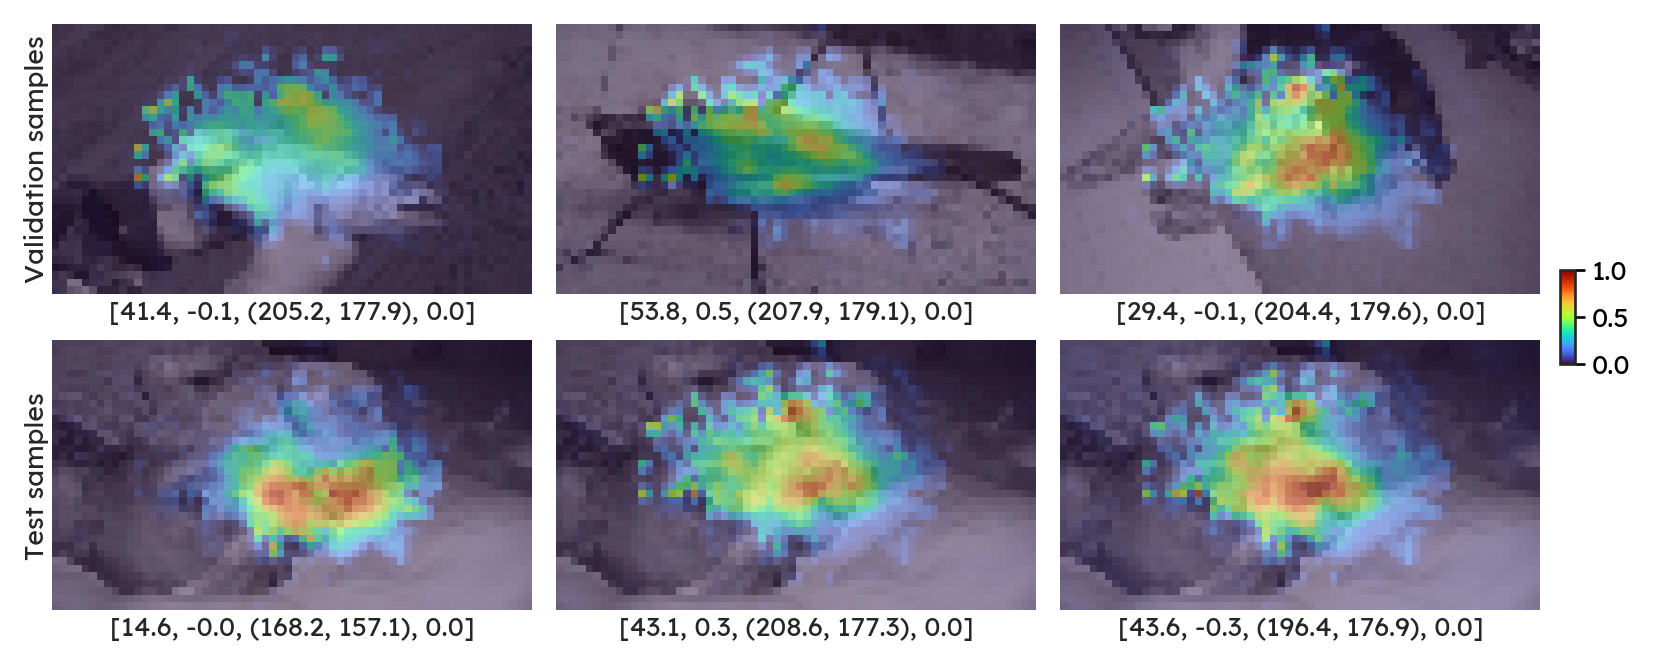

In [54]:
mouse_id = "A"

plot_attention_maps(
    val_results=results["validation"][mouse_id],
    test_results=results["test"][mouse_id],
    filename=os.path.join(PLOT_DIR, f"attention_rollout_mouse{mouse_id}.jpg"),
)

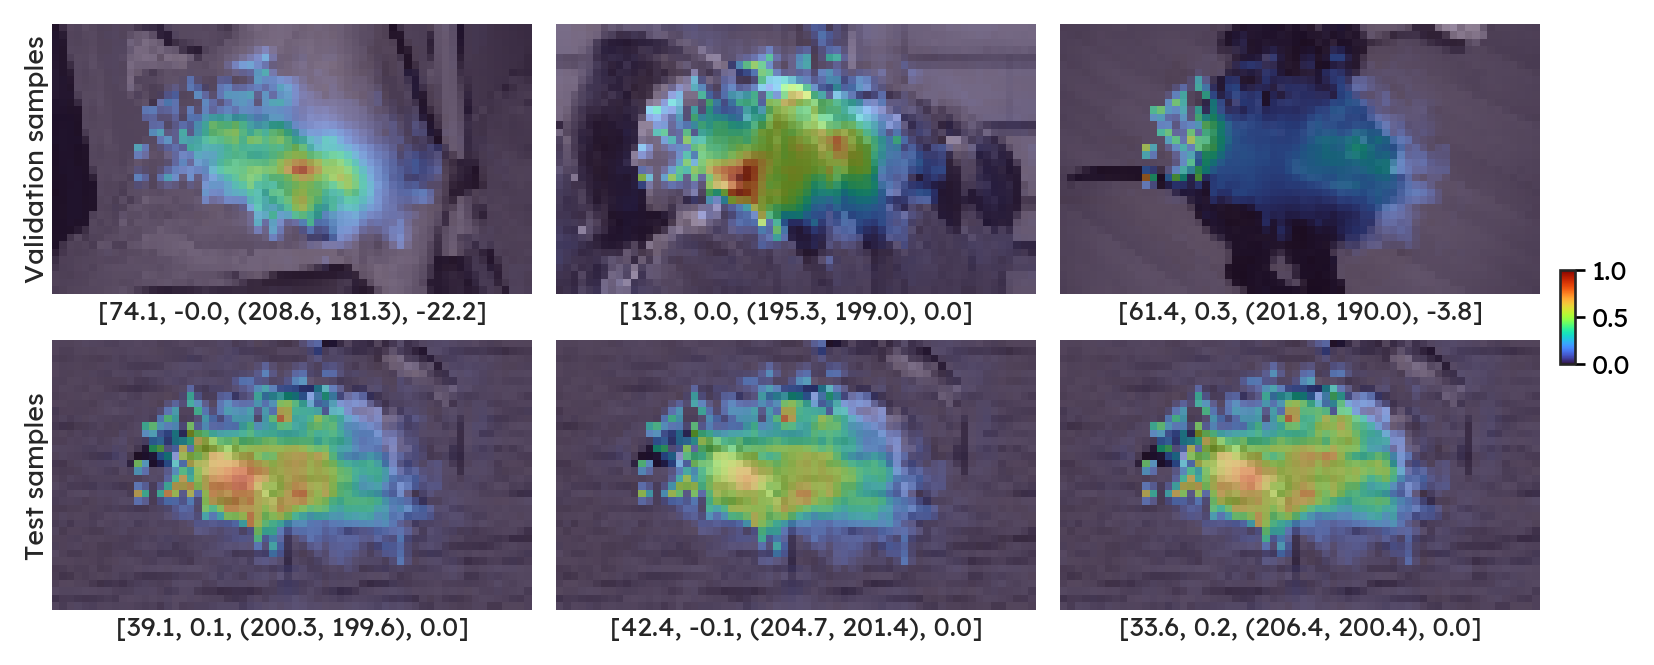

In [55]:
mouse_id = "B"

plot_attention_maps(
    val_results=results["validation"][mouse_id],
    test_results=results["test"][mouse_id],
    filename=os.path.join(PLOT_DIR, f"attention_rollout_mouse{mouse_id}.jpg"),
)

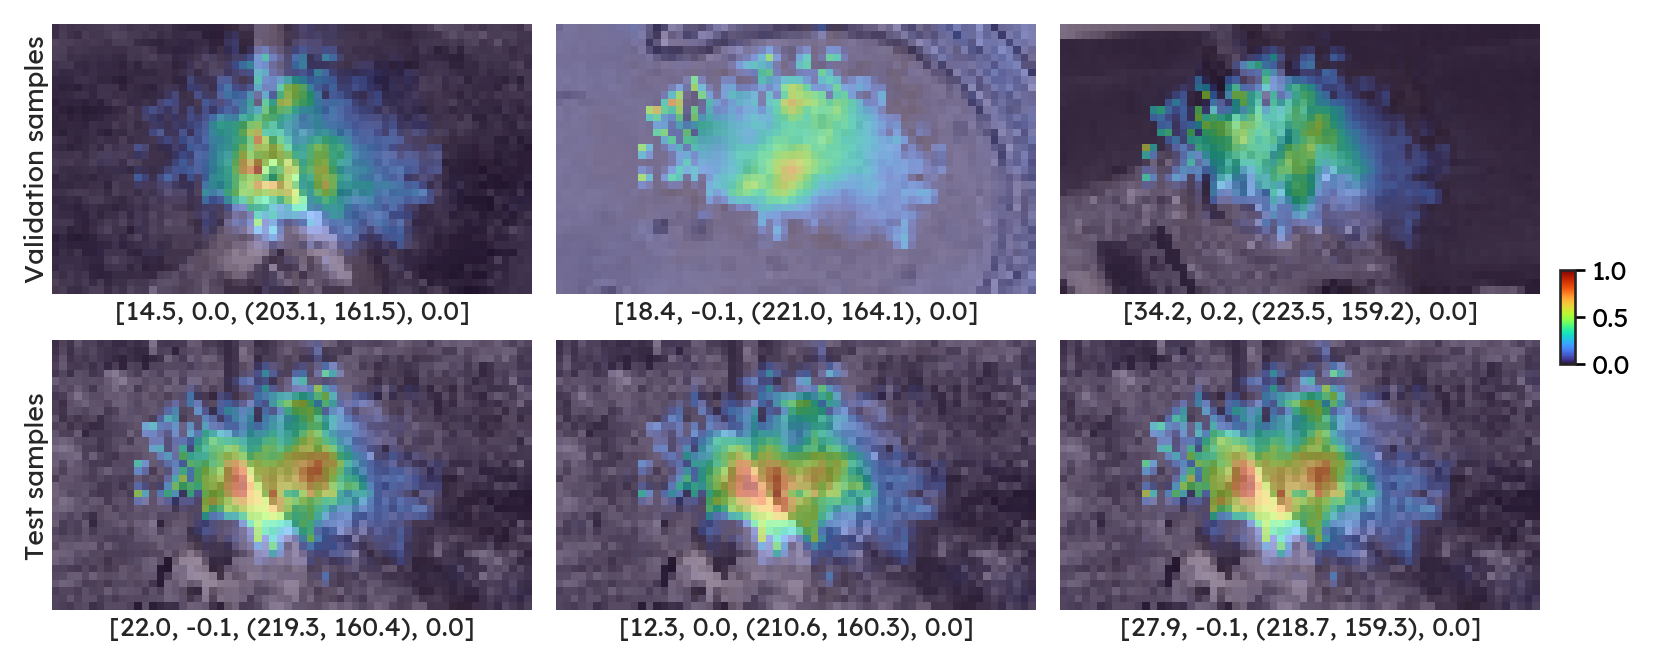

In [56]:
mouse_id = "C"

plot_attention_maps(
    val_results=results["validation"][mouse_id],
    test_results=results["test"][mouse_id],
    filename=os.path.join(PLOT_DIR, f"attention_rollout_mouse{mouse_id}.jpg"),
)

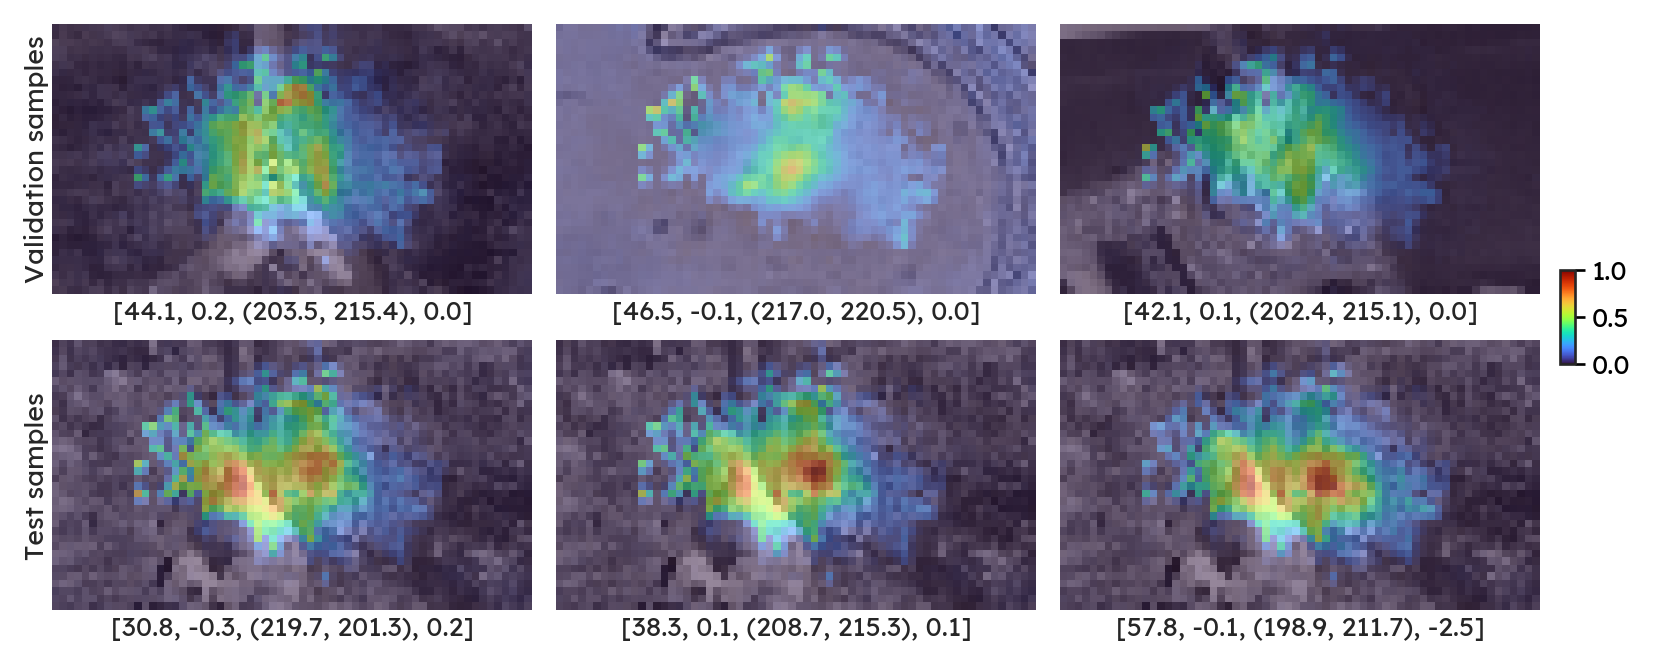

In [57]:
mouse_id = "D"

plot_attention_maps(
    val_results=results["validation"][mouse_id],
    test_results=results["test"][mouse_id],
    filename=os.path.join(PLOT_DIR, f"attention_rollout_mouse{mouse_id}.jpg"),
)

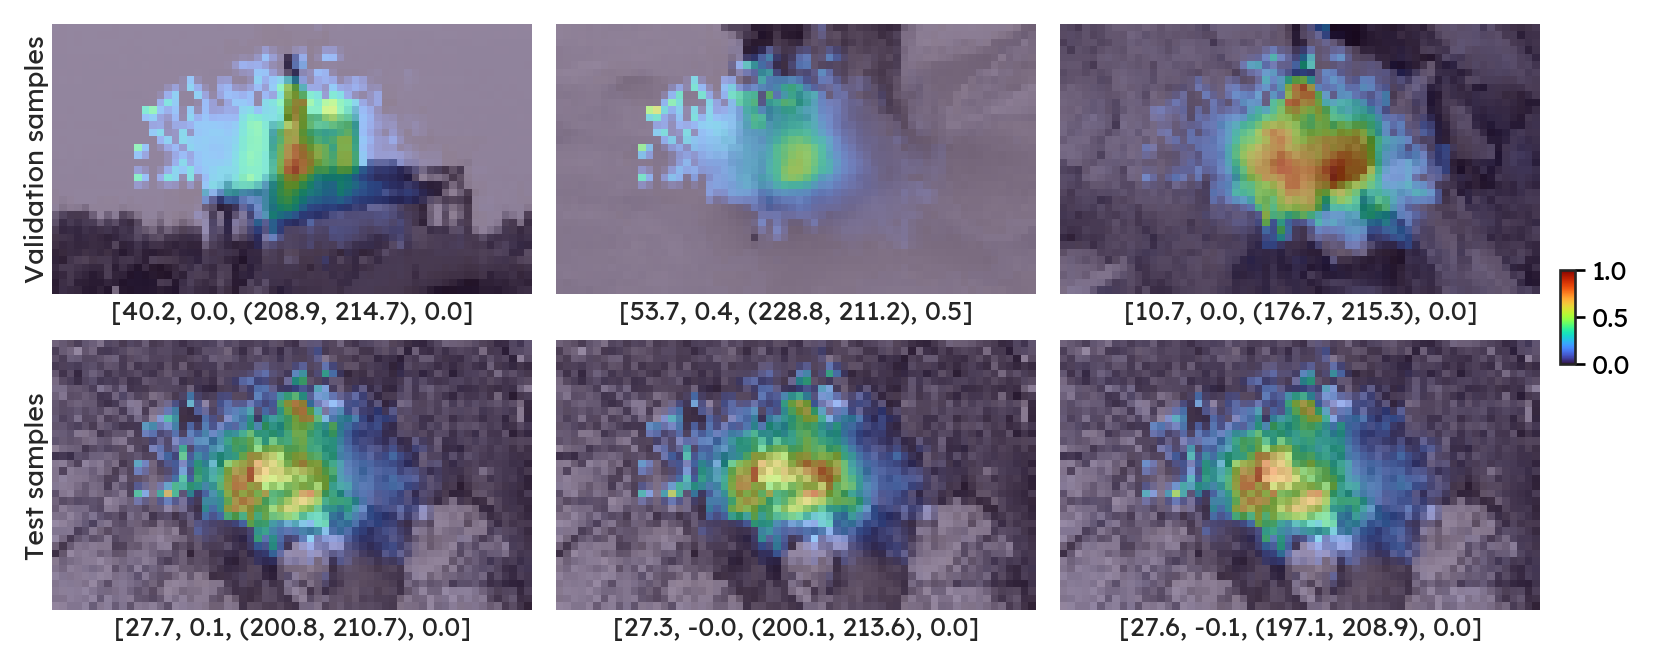

In [58]:
mouse_id = "E"

plot_attention_maps(
    val_results=results["validation"][mouse_id],
    test_results=results["test"][mouse_id],
    filename=os.path.join(PLOT_DIR, f"attention_rollout_mouse{mouse_id}.jpg"),
)